# AC-GAN (Auxiliary Classifier Gan)

This is an attempt to re-implement the paper AC-GAN

Paper: https://arxiv.org/pdf/1610.09585.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
path = 'E:\\Image Datasets\\Fruit Classification\\Dataset\\train'
dataset = tf.keras.preprocessing.image_dataset_from_directory(path, image_size = (64, 64))

Found 1212 files belonging to 6 classes.


In [3]:
class_names = dataset.class_names

In [4]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, neurons, gain = tf.sqrt(2.0), **kwargs):
        super().__init__(**kwargs)
        self.neurons = neurons
        self.gain = gain
        
    def build(self, input_shape):
        inp_neurons = input_shape[-1]
        
        init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
        self.W = self.add_weight(shape = (inp_neurons, self.neurons), initializer = init, 
                                 trainable = True, name = 'weight')
        self.B = self.add_weight(shape = (1, self.neurons), initializer = 'zeros', 
                                 trainable = True, name = 'bias')
        
        self.w_scale = self.gain * tf.math.rsqrt(tf.cast(inp_neurons, tf.float32))
    
    def call(self, inputs):
        return tf.add(tf.matmul(inputs, self.W * self.w_scale), self.B)

In [5]:
class Conv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, gain = tf.sqrt(2.0), **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = 'SAME' if (kernel_size[0] - 1)//2 else 'VALID'
        self.gain = gain
        
    def build(self, input_shape):
        inp_filters = input_shape[-1]
        
        init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
        self.kernel = self.add_weight(shape = self.kernel_size + (inp_filters, self.filters), initializer = init, 
                                      trainable = True, name = 'kernel')
        self.bias = self.add_weight(shape = (1, self.filters), initializer = 'zeros', 
                                    trainable = True, name = 'bias')
        
        fan_in = tf.cast(self.kernel_size[0] * self.kernel_size[1] * inp_filters, tf.float32)
        self.w_scale = self.gain * tf.math.rsqrt(fan_in)
        
    def call(self, inputs):
        return tf.add(tf.nn.conv2d(inputs, self.kernel * self.w_scale, strides = self.strides, padding = self.padding), 
                      self.bias)

In [6]:
class ACGAN(object):
    def __init__(self, latent_dim, num_classes):
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        self.gen_img_shape = self.generator.output_shape[1:]
    
    @property
    def generator(self):
        latent_inp = tf.keras.layers.Input(shape = self.latent_dim, dtype = tf.float32, 
                                           name = f'generator_latent_input_{self.latent_dim}')
        label_inp = tf.keras.layers.Input(shape = (1, ), dtype = tf.float32, name = f'generator_label_input')
        
        x_latent = Linear(neurons = 384, gain = tf.sqrt(2.0))(latent_inp)
        x_label = Linear(neurons = 384, gain = tf.sqrt(2.0))(label_inp)
        
        x = tf.keras.layers.Concatenate()([x_latent, x_label])
        x = Linear(neurons = 4 * 4 * 768, gain = tf.sqrt(2.0))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Reshape((4, 4, 768))(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 384, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 192, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        
        x = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(x)
        x = tf.keras.layers.Activation('tanh')(x)
        
        return tf.keras.models.Model([latent_inp, label_inp], x, name = 'generator')
    
    @property
    def discriminator(self):
        inp = tf.keras.layers.Input(shape = self.gen_img_shape, dtype = tf.float32, name = 'discriminator_input')
        
        x = Conv2D(filters = 16, kernel_size = (3, 3), strides = (2, 2), gain = tf.sqrt(2.0))(inp)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), gain = tf.sqrt(2.0))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = Conv2D(filters = 64, kernel_size = (3, 3), strides = (2, 2), gain = tf.sqrt(2.0))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), gain = tf.sqrt(2.0))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = Conv2D(filters = 256, kernel_size = (3, 3), strides = (2, 2), gain = tf.sqrt(2.0))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), gain = tf.sqrt(2.0))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
        
        x = tf.keras.layers.Flatten()(x)
        validity_out = Linear(neurons = 1, gain = tf.sqrt(1.0))(x)
        label_out = Linear(neurons = self.num_classes, gain = tf.sqrt(1.0))(x)
        
        return tf.keras.models.Model(inp, [validity_out, label_out], name = 'discriminator')

In [18]:
class Losses(object):
    def __init__(self):
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
        self.cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
        
    def discriminator_loss(self, disc_real_out, disc_gen_out, real_labels, disc_real_cls_out, disc_gen_cls_out):
        real_loss = self.bce(tf.ones_like(disc_real_out), disc_real_out)
        gen_loss = self.bce(tf.zeros_like(disc_gen_out), disc_gen_out)
        
        real_cls_loss = self.cce(real_labels, disc_real_cls_out)
        gen_cls_loss = self.cce(real_labels, disc_gen_cls_out)
        
        tot_loss = real_loss + gen_loss + real_cls_loss  + gen_cls_loss
        return tot_loss
    
    def generator_loss(self, disc_gen_out, disc_gen_cls_out, real_labels):
        gen_loss = self.bce(tf.ones_like(disc_gen_out), disc_gen_out)
        gen_cls_loss = self.cce(real_labels, disc_gen_cls_out)
        return gen_loss + gen_cls_loss

In [19]:
class Trainer(object):
    def __init__(self, latent_dim, num_classes, learning_rate = 2e-4):
        self.latent_dim = latent_dim
        
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.5, beta_2 = 0.999)
        self.disc_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.5, beta_2 = 0.999)
        
        gan = ACGAN(latent_dim = latent_dim, num_classes = num_classes)
        self.generator = gan.generator
        self.discriminator = gan.discriminator
        
        self.losses = Losses()
        
    def generate_latent_space(self, batch_size):
        return tf.random.normal((batch_size, self.latent_dim))
    
    def __rescale(self, x):
        return (x/127.5) - 1
    
    def train(self, data, epochs = 1):
        gen_losses, disc_losses = [], []
        for e in range(epochs):
            print(f'Epoch: {e} Starts')
            for real_img, real_label in data:
                gen_loss, disc_loss = self.train_step(self.__rescale(real_img), real_label)
                print('.', end = '')
                
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)
            print(f'\nGenerator Loss: {gen_loss} \t Discriminator Loss: {disc_loss}')
            print(f'Epoch: {e} Ends\n')
            
        return {'gen_losses': gen_losses, 'disc_losses': disc_losses}
        
    @tf.function
    def train_step(self, real_img, real_label):
        
        latent_inp = self.generate_latent_space(real_img.shape[0])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_out = self.generator([latent_inp, real_label], training = True)
            
            disc_real_out, disc_real_cls_out = self.discriminator(real_img, training = True)
            disc_gen_out, disc_gen_cls_out = self.discriminator(gen_out, training = True)
            
            disc_loss = self.losses.discriminator_loss(disc_real_out, disc_gen_out, real_label, disc_real_cls_out, 
                                                       disc_gen_cls_out)
            gen_loss = self.losses.generator_loss(disc_gen_out, disc_gen_cls_out, real_label)
            
        gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        
        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        
        return gen_loss, disc_loss

In [20]:
trainer = Trainer(100, len(dataset.class_names))

In [46]:
training_losses = trainer.train(dataset, 1)

Epoch: 0 Starts
......................................
Generator Loss: 0.7729328274726868 	 Discriminator Loss: 1.8767207860946655
Epoch: 0 Ends



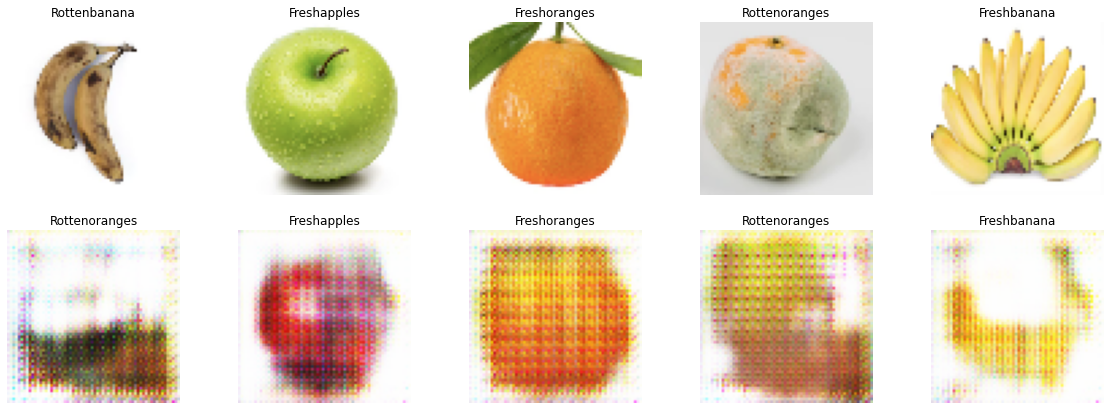

In [49]:
sample_data = next(iter(dataset))
label = np.array(class_names)[sample_data[1]]

gen_img = trainer.generator([tf.random.normal((32, 100)), sample_data[1]])
gen_label = np.array(class_names)[tf.argmax(trainer.discriminator(gen_img)[1], axis = -1).numpy()]

plt.figure(figsize = (20, 7))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_data[0][i].numpy().astype('uint8'))
    plt.title(label[i].title())
    plt.axis('off')

    plt.subplot(2, 5, i+1+5)
    plt.imshow(((gen_img[i] + 1)*127.5).numpy().astype('uint8'))
    plt.title(gen_label[i].title())
    plt.axis('off')

plt.show()

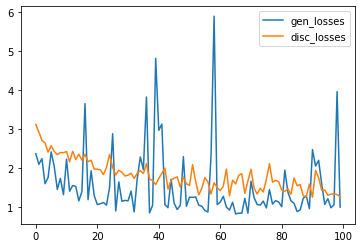

In [13]:
plt.plot(training_losses['gen_losses'], label = 'gen_losses')
plt.plot(training_losses['disc_losses'], label = 'disc_losses')
plt.legend()
plt.show()